In [2]:
from datetime import date
from qutip import *
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

In [3]:
def plot_wigner(rho, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax=plt.subplots(1,1,figsize=(8,8))
    if isket(rho):
        rho=ket2dm(rho)
    xvec=linspace(-7.5, 7.5, 200)
    W=wigner(rho,xvec,xvec)
    wlim=abs(W).max()
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'x1', fontsize=16)
    ax.set_ylabel(r'x2', fontsize=16)
    return fig, ax

In [38]:
class system:
    def __init__(self, chi, tau_speed, ramp, catsize, start, stop, num):
        self.purechi=chi
        self.chi=chi*(2)*pi
        self.ramp=ramp
        self.catsize=catsize
        self.tau_speed=tau_speed
        self.tau=self.tau_speed/self.chi #puri=5, frattini=2.14
        self.start=start
        self.stop=stop
        self.num=num
        self.tlist=linspace(self.start, self.stop, self.num)
        self.N=15
        self.x_chi=[]
        self.y_v=[]
        self.fidelity=[]
        self.a=destroy(self.N)
        self.ad=self.a.dag()
        self.H0=self.ad*self.ad*self.a*self.a
        self.Hdet=self.ad*self.a
        self.Hx=self.ad*self.ad+self.a*self.a
        self.Hy=self.ad*self.ad-self.a*self.a
        self.zero=basis(self.N, 0)
        self.one=basis(self.N, 1)
        self.N_plus=(1/(sqrt(2*(1+(exp((-2)*self.catsize))))))
        self.zero=coherent(self.N, 0)
        self.P0=self.catsize*self.chi
        self.expectedcat=self.N_plus*(coherent(self.N, sqrt(self.catsize))+coherent(self.N, -sqrt(self.catsize)))
    def Epx(self, t, args):
        if self.ramp == 'ad_exp':
            return self.P0 *(1-exp((-(t)**4)/(self.tau**4)))
        elif self.ramp == 'ad_tanh':
            return self.P0*tanh(4*(t/self.tau))
        elif self.ramp == 'lin':
            if t<self.tau:
                return self.P0*(t/self.tau) 
            if t>=self.tau :
                return self.P0
        elif self.ramp =='inst':
            return self.P0   
    def det(self, t, args):
        return (-1.7)*(1-(t/self.tau))     
    def Epy(self, t,args):
        Ep= self.P0*self.chi*(1-exp((-(t)**4)/(self.tau**4)))
        alpha_0=sqrt(Ep/self.chi)
        alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/(self.tau**4)))))*((-1)*self.catsize*exp((-(t)**4)/(self.tau**4)))*((-4)*(t**3)/(self.tau**4)))
        N_m=1/(sqrt(2*(1-exp((-2)*(self.catsize)))))
        return (1j*alpha_prime)/((1+2*alpha_0)*(N_m))
    def init_fidelity(self, spec,kstart, kstop, knum, vstart, vstop, vnum): 
        kerr=linspace(kstart, kstop, knum)
        tau_speed=linspace(vstart,vstop, vnum)
        x=[]
        y=[]
        fid=[]
        for chi in kerr:
            for v in tau_speed:
                def Epx_k_speed(t, args):
                    return (2*pi)*chi*self.catsize*(1-exp((-(t)**4)/((v/(2*pi)*chi)**4)))
                result=mesolve([(-1)*(2*pi)*chi*self.H0,[self.Hx, Epx_k_speed]],self.zero, self.tlist, [], [])
                f=[]
                for i in range(len(self.tlist)):
                    f.append(fidelity(self.expectedcat, result.states[i]))
                maxfid=max(f)
                f.clear()
                self.x_chi.append(chi)
                self.y_v.append(v)
                self.fidelity.append(round(maxfid*100,4))
                if maxfid<0.9:
                    pass
                if maxfid>=0.9:
                    x.append(chi)
                    y.append(v)
                    fid.append(round(maxfid*100,4))
        plt.scatter(x,y,c=fid, s=20, cmap=plt.cm.viridis, alpha=1)
        #plt.scatter(self.x_chi,self.y_v,c=self.fidelity, s=20, cmap=plt.cm.viridis, alpha=1,vmin=90, vmax=100)
        plt.xlabel('kerr(MHz)')
        plt.ylabel('ramp speed')
        plt.colorbar(label='fidelity(%)')
        name=f"{spec},n={self.catsize},k=({kstart},{kstop},{knum}),v=({vstart},{vstop},{vnum})"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/data/fidelity/230213/{name}.png"
        plt.savefig(file_name, format='png', dpi=100, bbox_inches='tight')
        plt.show()
        
    def generate(self, H, spec, speed):
        n=len(self.tlist)
        if H=='x':
            H=[(-1)*self.chi*self.H0,[self.Hx, self.Epx]]
        elif H=='x,y':
            H=[(-1)*self.chi*self.H0,[self.Hx, self.Epx],[self.Hy, self.Epy]]
        elif H=='x,det':
            H=[(-1)*self.chi*self.H0,[self.Hx, self.Epx],[self.Hdet, self.det]]
        result=mesolve(H, self.zero, self.tlist, [], [])        
        # fidelity, time
        f=[]
        for i in range(n):
            f.append(fidelity(self.expectedcat, result.states[i]))
        maxfid=max(f)
        maxfid_idx=f.index(maxfid)
        time_taken=((self.stop-self.start)/self.num)*(maxfid_idx+1)
        # animation
        fig, ax= plt.subplots(1,1,figsize=(8,8))
        def update(frame):
            plot_wigner(result.states[frame*speed], fig=fig, ax=ax)
        ani=animation.FuncAnimation(fig, update, frames=int(n/speed))
        FFwriter=animation.FFMpegWriter()
        name=f"{spec},F={round(maxfid*100,4)},time={round(time_taken,3)}us,chi={self.purechi},v={self.tau_speed},n={self.catsize},t=({self.start},{self.stop},{self.num}).mp4"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/animation/230213/{name}.mp4"
        ani.save(file_name, writer=FFwriter)
        plt.close()
        return maxfid, time_taken

In [39]:
sys=system(chi=0.75, tau_speed=5, ramp='ad_exp', catsize=2.6, start=0, stop=3,num=2000)


In [41]:
sys.init_fidelity('ad_exp',0.35, 80, 100, 0.01,30, 100)

KeyboardInterrupt: 

In [ ]:
sys.generate(H='adiabatic', spec='ad_exp', speed=20)

(0.998500370278381, 1.3800000000000001)

In [65]:
sys_lin=system(chi=0.75, tau_speed=5, ramp='lin', catsize=4, start=0, stop=2,num=500)


In [66]:
sys.generate(H='adiabatic', spec='ad_exp', speed=20)

(0.998500370278381, 1.3800000000000001)

In [64]:
sys.generate(H='drv+det', spec='ad_exp,ad_det', speed=20)

(0.9994474023327627, 1.932)

In [67]:
sys_lin.generate(H='drv+det', spec='ad_lin,ad_det', speed=20)

(0.9955463654702429, 0.9480000000000001)

[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 9.555555555555555, 9.555555555555555, 18.36111111111111, 27.166666666666664, 35.97222222222222, 44.77777777777778, 53.58333333333333, 62.388888888888886, 71.19444444444444, 80.0]
[2.231111111111111, 4.452222222222222, 6.673333333333333, 8.894444444444444, 11.115555555555554, 13.336666666666666, 15.557777777777778, 17.77888888888889, 20.0, 0.01, 2.231111111111111, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[82.3607, 94.7612, 99.0027, 99.8528, 99.9824, 100.0055, 100.0094, 99.9929, 99.6363, 68.7723, 80.4065, 97.9598, 100.0039, 100.011, 100.011, 100.011, 100.011, 100.011, 100.011]


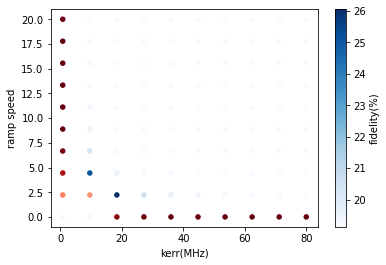

In [49]:
sys.init_fidelity(0.75, 80, 10, 0.01, 20, 10)

In [46]:
sys.init_fidelity(0.35, 80, 100, 0.01, 20, 100)

KeyboardInterrupt: 

[0.75, 0.75, 0.75]
[5.0, 7.5, 10.0]
[96.8406, 99.5558, 99.9414]


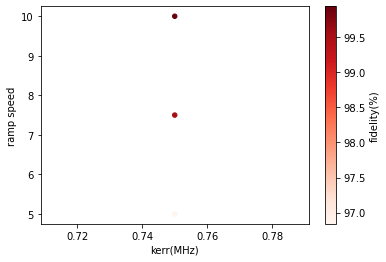

In [ ]:
sys.init_fidelity(0.75, 80, 3, 5, 10, 3)

[0.75, 0.75, 0.75, 40.375, 40.375, 40.375, 80.0, 80.0, 80.0]
[5.0, 7.5, 10.0, 5.0, 7.5, 10.0, 5.0, 7.5, 10.0]
[96.8406, 99.5558, 99.9414, 19.1488, 19.1395, 19.1379, 19.138, 19.1374, 19.1373]


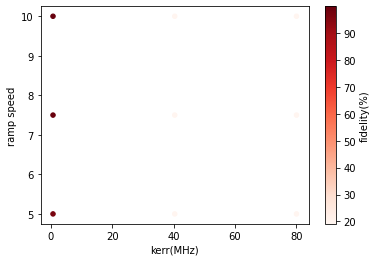

In [ ]:
sys.init_fidelity(0.75, 80, 3, 5, 10, 3)

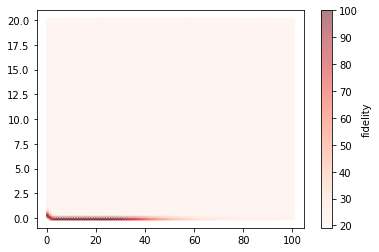

In [26]:
sys.init_fidelity() #10000 pt 275min

In [10]:
sys.generate('adiabatic','K',  20)

(0.9985003605227244, 1.3800000000000001)

In [32]:
sys=system(-0.75, 5, 'ad_exp', 4)

In [33]:
sys.generate('adiabatic','K', 0, 2, 500, 20)

(0.9985003634474527, 1.3800000000000001)

In [34]:
sys=system(-0.075, 5, 'ad_exp', 4)

In [35]:
sys.generate('adiabatic','0.1K', 0, 18, 500, 20)

(0.9985142334532595, 13.787999999999998)

In [36]:
sys=system(75, 5, 'ad_exp', 4)

In [37]:
sys.generate('adiabatic','100K', 0, 0.1, 500, 20)

(0.9982953398900526, 0.014)